## Imports

In [1]:
import os
# The following filters out unimportant warnings, see https://github.com/tensorflow/tensorflow/issues/59779
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score
import tensorflow_addons as tfa
import datetime

/Users/jjurm/workspace/ML4H-Project-2/venv3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load the dataset

already preprocessed and split into train_val and test sets.

In [3]:
# How much of the dataset to use (the rest of train_val and test is discarded)
SAMPLE_FRAC = 0.1

# the following function removes some artefacts from the dataset files (duplicated indices and wrong dtypes)
def read_pickle(filename):
    df = pd.read_pickle(filename)
    df.index = df.index.astype('int32')
    df = df[~df.index.duplicated(keep='first')]
    return df

x_train_val = read_pickle("export/x_train_val_262k.pkl").sample(frac=SAMPLE_FRAC, replace=False, random_state=0)
y_train_val = read_pickle("export/y_train_val_262k.pkl").loc[x_train_val.index].astype('int32')
x_test = read_pickle("export/x_test_129k.pkl").sample(frac=SAMPLE_FRAC, replace=False, random_state=0)
y_test = read_pickle("export/y_test_129k.pkl").loc[x_test.index].astype('int32')

x_train = x_train_val.sample(frac=0.95, replace=False, random_state=0)
y_train = y_train_val.loc[x_train.index]
x_val = x_train_val.drop(x_train.index)
y_val = y_train_val.drop(y_train.index)

del x_train_val, y_train_val

assert(len(x_train) == len(y_train))
assert(len(x_val) == len(y_val))
assert(len(x_test) == len(y_test))
print("Train size:", len(x_train))
print("Val size:", len(x_val))
print("Test size:", len(x_test))

Train size: 24639
Val size: 1297
Test size: 12858


## Tokenize the dataset

and turn into `tf.data.Dataset` objects.

In [4]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

BATCH_SIZE = 32
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
MODEL_NAME_SHORT = "".join(map(lambda w: w[0], MODEL_NAME.split("-")))
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def to_tf_dataset(x, y):
    tokenized_data = tokenizer(x['unigram'].str.join(' ').tolist(), return_tensors="np", padding=True)
    labels = y.values
    return tf.data.Dataset.from_tensor_slices((
        {'input_ids': tokenized_data['input_ids']},
        labels
    ))

train_data = to_tf_dataset(x_train, y_train).batch(BATCH_SIZE)
val_data = to_tf_dataset(x_val, y_val).batch(BATCH_SIZE)
test_data = to_tf_dataset(x_test, y_test).batch(BATCH_SIZE)

## Build the model

### Custom model class

We extend the `TFDistilBertForSequenceClassification` class to add a regression head with two outputs on top of the pre-trained model.

In [5]:
from transformers import TFDistilBertMainLayer
from transformers.modeling_tf_utils import get_initializer, unpack_inputs, TFModelInputType
from transformers.utils.generic import ModelOutput
from typing import Optional, Union, Tuple
from dataclasses import dataclass

@dataclass
class TFSentiStrengthRegressionOutput(ModelOutput):
    loss: Optional[tf.Tensor] = None
    values: Optional[tf.Tensor] = None
    hidden_states: Optional[Tuple[tf.Tensor]] = None
    attentions: Optional[Tuple[tf.Tensor]] = None

class TFDistilBertForSentiStrengthRegression(TFDistilBertForSequenceClassification):
    def __init__(self, config, *inputs, **kwargs):
        super(TFDistilBertForSequenceClassification, self).__init__(config, *inputs, **kwargs)

        self.distilbert = TFDistilBertMainLayer(config, name="distilbert")
        self.pre_regression = tf.keras.layers.Dense(
            config.dim,
            kernel_initializer=get_initializer(config.initializer_range),
            activation="relu",
            name="pre_regression",
        )
        self.regression = tf.keras.layers.Dense(
            units=2, kernel_initializer=get_initializer(config.initializer_range), name="regression",
            activation='linear'
        )
        self.dropout = tf.keras.layers.Dropout(config.seq_classif_dropout)

    @unpack_inputs
    def call(
            self,
            input_ids: Optional[TFModelInputType] = None,
            attention_mask: Optional[Union[np.ndarray, tf.Tensor]] = None,
            head_mask: Optional[Union[np.ndarray, tf.Tensor]] = None,
            inputs_embeds: Optional[Union[np.ndarray, tf.Tensor]] = None,
            output_attentions: Optional[bool] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
            labels: Optional[Union[np.ndarray, tf.Tensor]] = None,
            training: Optional[bool] = False,
    ) -> Union[TFSentiStrengthRegressionOutput, Tuple[tf.Tensor]]:
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            training=training,
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_regression(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output, training=training)  # (bs, dim)
        values = self.regression(pooled_output)  # (bs, dim)

        loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
        loss = None if labels is None else loss_fn(labels, values)

        if not return_dict:
            output = (values,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return TFSentiStrengthRegressionOutput(
            loss=loss,
            values=values,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

def build_model(trainable=False):
    bert = TFDistilBertForSentiStrengthRegression.from_pretrained(MODEL_NAME, seq_classif_dropout=0)
    bert.layers[0].trainable = trainable

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    outputs = bert(input_ids).values

    model = tf.keras.models.Model(
        inputs=[input_ids],
        outputs=[outputs],
        name=MODEL_NAME_SHORT,)

    def mse_sum(y_true, y_pred):
        return tf.keras.metrics.mean_squared_error(y_true[0], y_pred[0]) + tf.keras.metrics.mean_squared_error(y_true[1], y_pred[1])
    def mae_sum(y_true, y_pred):
        return tf.keras.metrics.mean_absolute_error(y_true[0], y_pred[0]) + tf.keras.metrics.mean_absolute_error(y_true[1], y_pred[1])
    def mae_pos(y_true, y_pred):
        return tf.keras.metrics.mean_absolute_error(y_true[0], y_pred[0])
    def mae_neg(y_true, y_pred):
        return tf.keras.metrics.mean_absolute_error(y_true[1], y_pred[1])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=mse_sum,
        metrics=[mae_sum, mae_pos, mae_neg],)
    return model

### Custom Metrics

The `Metrics` class evaluates the model on the validation data after each epoch and stores the results. It also stores the results in the `history` object of the model. This allows us to plot the results later on.

In [6]:
from scipy.stats import hmean

# inspired by https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
# and adapted by https://github.com/keras-team/keras/issues/10472#issuecomment-472543538
# due to the issue that validation_data of our custom callback object won't be set
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, val_data, print_metrics=True):
        super().__init__()
        self.validation_data = val_data
        self.print_metrics = print_metrics
        self.val_f1w_hm = None # Harmonic mean
        self.val_f1w_pos = None
        self.val_f1w_neg = None

    def on_train_begin(self, logs={}):
        self.val_f1w_hm = []
        self.val_f1w_pos = []
        self.val_f1w_neg = []
        return

    def on_epoch_end(self, epoch, logs={}):
        total = sum(len(y) for (x, y) in self.validation_data)
        val_pred = np.zeros((total,2))
        val_true = np.zeros((total,2))
        # collect val_pred and val_true for all batches in validation_data
        from_idx = 0
        for batch, (xVal, yVal) in enumerate(self.validation_data):
            val_true[from_idx : from_idx + len(yVal)] = yVal
            val_pred[from_idx : from_idx + len(yVal)] = np.asarray(self.model.predict(xVal, verbose=0)).round().astype('int32')
            from_idx += len(yVal)

        val_f1w_pos = f1_score(val_true[:,0], val_pred[:,0], average='weighted')
        val_f1w_neg = f1_score(val_true[:,1], val_pred[:,1], average='weighted')
        val_f1w_hm = hmean([val_f1w_pos, val_f1w_neg])
        self.val_f1w_hm.append(val_f1w_hm)
        self.val_f1w_pos.append(val_f1w_pos)
        self.val_f1w_neg.append(val_f1w_neg)

        logs["val_f1w_hm"] = val_f1w_hm
        logs["val_f1w_pos"] = val_f1w_pos
        logs["val_f1w_neg"] = val_f1w_neg

        if self.print_metrics:
            print(" - val_f1w_hm: %f - val_f1w_pos: %f - val_f1w_neg %f" % (val_f1w_hm, val_f1w_pos, val_f1w_neg))
        return

    def get_last_values_dict(self):
        return {
            'val_f1w_hm': self.val_f1w_hm[-1],
            'val_f1w_pos': self.val_f1w_pos[-1],
            'val_f1w_neg': self.val_f1w_neg[-1],
        } if len(self.val_f1w_hm) > 0 else {}

metrics = Metrics(
    val_data=val_data,
    print_metrics=False,
)

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSentiStrengthRegression: ['pre_classifier', 'classifier']
- This IS expected if you are initializing TFDistilBertForSentiStrengthRegression from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSentiStrengthRegression from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSentiStrengthRegression were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['pre_regression', 'regression']
You should probably TRAIN this model on a down-stream task to be able to use it for

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


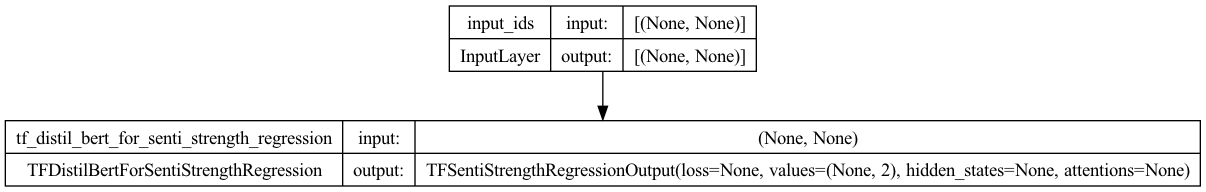

In [7]:
model = build_model()
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [8]:
class ModelCheckpointCustomPath(tf.keras.callbacks.ModelCheckpoint):
    def _get_file_path(self, epoch, batch, logs):
        return super()._get_file_path(epoch, batch, {**logs, 'model': self.model.name})

date_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = './logs/'+date_str+'/{model}.epoch-{epoch:02d}.val_f1w_hm-{val_f1w_hm:.2f}.hdf5'
model_checkpoint_callback = ModelCheckpointCustomPath(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_f1w_hm',
    mode='max',
    save_best_only=False)

log_dir = "logs/"+date_str+"/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x=train_data,
    validation_data=val_data,
    epochs=5,
    verbose=0,
    callbacks=[metrics, model_checkpoint_callback, tensorboard_callback, tfa.callbacks.TQDMProgressBar()],
)

Training:   0%|           0/5 ETA: ?s,  ?epochs/s

Epoch 1/5


0/770           ETA: ?s - 

KeyboardInterrupt: 